## Image Features

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# read the data
data1=pd.read_csv("imagefeatures.csv")
data=pd.read_csv('data_phenotypic.csv')
# data.head()
# data1.drop("Unnamed: 0",inplace=True,axis=1)
data['DX_GROUP']=data['DX_GROUP'].replace(2,0)

X = data1
y = data['DX_GROUP']

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)
# Create instances of the classifiers
decision_tree = DecisionTreeClassifier()
adaboost_classifier = AdaBoostClassifier()
xgb_classifier = XGBClassifier()
# lgbm_classifier = lgb.LGBMClassifier()
gradient_boost_classifier = GradientBoostingClassifier()
random_forest = RandomForestClassifier()

# Define the majority voting classifier
models = {
    "Decision Tree": decision_tree,
    "AdaBoost Classifier": adaboost_classifier,
    "XGBClassifier": xgb_classifier,
    # "LightGBM Classifier": lgbm_classifier,
    "Gradient Boost Classifier": gradient_boost_classifier,
    "RandomForest": random_forest
}

majority_voting_classifier = VotingClassifier(estimators=list(models.items()), voting='hard')

# Train each individual classifier
for name, model in models.items():
    model.fit(X_train, y_train)

# Train the majority voting classifier
majority_voting_classifier.fit(X_train, y_train)

# Initialize lists to store metrics
model_names = list(models.keys()) + ['Majority Voting']
precision_scores = []
recall_scores = []
f1_scores = []
accuracy_scores = []

# Predictions for each individual classifier on the test set
individual_predictions = {name: model.predict(X_test) for name, model in models.items()}

# Predictions for the majority voting classifier on the test set
majority_voting_predictions = majority_voting_classifier.predict(X_test)

# Calculate metrics for each individual classifier
for name, predictions in individual_predictions.items():
    precision_scores.append(precision_score(y_test, predictions))
    recall_scores.append(recall_score(y_test, predictions))
    f1_scores.append(f1_score(y_test, predictions))
    accuracy_scores.append(accuracy_score(y_test, predictions))

# Calculate metrics for the majority voting classifier
precision_scores.append(precision_score(y_test, majority_voting_predictions))
recall_scores.append(recall_score(y_test, majority_voting_predictions))
f1_scores.append(f1_score(y_test, majority_voting_predictions))
accuracy_scores.append(accuracy_score(y_test, majority_voting_predictions))

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Model': model_names,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1 Score': f1_scores,
    'Accuracy': accuracy_scores
})

# Print the results table
print(results_df)

# Plot ROC curves for classifiers that support predict_proba
plt.figure(figsize=(8, 6))
for name, model in models.items():
    if hasattr(model, 'predict_proba'):
        fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Approximate ROC curve for majority voting
majority_probs = np.sum(list(individual_predictions.values()), axis=0) / len(models)
fpr_majority, tpr_majority, _ = roc_curve(y_test, majority_probs)
roc_auc_majority = auc(fpr_majority, tpr_majority)
plt.plot(fpr_majority, tpr_majority, label=f'Majority Voting (AUC = {roc_auc_majority:.2f})', linestyle='--')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--', linewidth=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curves_sMRI')
plt.legend(loc='lower right')
plt.savefig('roc_curve.png')
plt.show()


                       Model  Precision    Recall  F1 Score  Accuracy  \
0              Decision Tree   0.990654  1.000000  0.995305  0.995455   
1        AdaBoost Classifier   0.990654  1.000000  0.995305  0.995455   
2              XGBClassifier   0.990654  1.000000  0.995305  0.995455   
3  Gradient Boost Classifier   0.990654  1.000000  0.995305  0.995455   
4               RandomForest   1.000000  0.962264  0.980769  0.981818   
5            Majority Voting   0.990654  1.000000  0.995305  0.995455   

   Specificity  
0     0.991228  
1     0.991228  
2     0.991228  
3     0.991228  
4     1.000000  
5     0.991228  


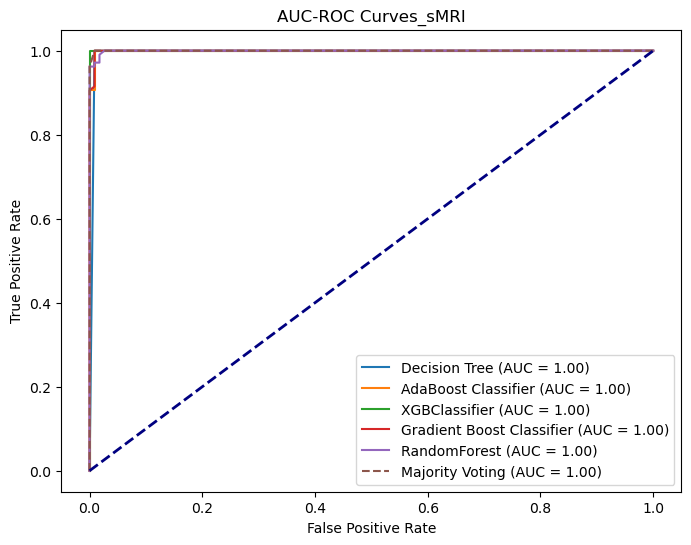

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Read the data
data = pd.read_csv('data_phenotypic.csv')

# Data preprocessing (replacing 2 with 0 for the target variable 'DX_GROUP')
data['DX_GROUP'] = data['DX_GROUP'].replace(2, 0)

# Defining feature matrix X and target vector y
X = data.drop('DX_GROUP', axis=1)
y = data['DX_GROUP']

# Splitting data into training and testing sets (80% train, 20% test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Create instances of the classifiers
decision_tree = DecisionTreeClassifier()
adaboost_classifier = AdaBoostClassifier()
xgb_classifier = XGBClassifier()
gradient_boost_classifier = GradientBoostingClassifier()
random_forest = RandomForestClassifier()

# Define the models in a dictionary
models = {
    "Decision Tree": decision_tree,
    "AdaBoost Classifier": adaboost_classifier,
    "XGBClassifier": xgb_classifier,
    "Gradient Boost Classifier": gradient_boost_classifier,
    "RandomForest": random_forest
}

# Define majority voting classifier
majority_voting_classifier = VotingClassifier(estimators=list(models.items()), voting='hard')

# Train each individual classifier
for name, model in models.items():
    model.fit(X_train, y_train)

# Train the majority voting classifier
majority_voting_classifier.fit(X_train, y_train)

# Initialize lists to store metrics
model_names = list(models.keys()) + ['Majority Voting']
precision_scores = []
recall_scores = []
f1_scores = []
accuracy_scores = []
specificity_scores = []

# Function to calculate specificity from confusion matrix
def calculate_specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return specificity

# Predictions for each individual classifier on the test set
individual_predictions = {name: model.predict(X_test) for name, model in models.items()}

# Predictions for the majority voting classifier on the test set
majority_voting_predictions = majority_voting_classifier.predict(X_test)

# Calculate metrics for each individual classifier
for name, predictions in individual_predictions.items():
    precision_scores.append(precision_score(y_test, predictions))
    recall_scores.append(recall_score(y_test, predictions))
    f1_scores.append(f1_score(y_test, predictions))
    accuracy_scores.append(accuracy_score(y_test, predictions))
    specificity_scores.append(calculate_specificity(y_test, predictions))

# Calculate metrics for the majority voting classifier
precision_scores.append(precision_score(y_test, majority_voting_predictions))
recall_scores.append(recall_score(y_test, majority_voting_predictions))
f1_scores.append(f1_score(y_test, majority_voting_predictions))
accuracy_scores.append(accuracy_score(y_test, majority_voting_predictions))
specificity_scores.append(calculate_specificity(y_test, majority_voting_predictions))

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Model': model_names,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1 Score': f1_scores,
    'Accuracy': accuracy_scores,
    'Specificity': specificity_scores
})

# Print the results table
print(results_df)

# Plot ROC curves for classifiers that support predict_proba
plt.figure(figsize=(8, 6))
for name, model in models.items():
    if hasattr(model, 'predict_proba'):
        fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Approximate ROC curve for majority voting
majority_probs = np.sum(list(individual_predictions.values()), axis=0) / len(models)
fpr_majority, tpr_majority, _ = roc_curve(y_test, majority_probs)
roc_auc_majority = auc(fpr_majority, tpr_majority)
plt.plot(fpr_majority, tpr_majority, label=f'Majority Voting (AUC = {roc_auc_majority:.2f})', linestyle='--')

# Plotting the diagonal line for random guessing
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', linewidth=2)

# Adding labels and title to the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curves_sMRI')
plt.legend(loc='lower right')

# Save the ROC curve figure
# plt.savefig('roc_curve.png')

# Show the ROC curve plot
plt.show()


## Phenotype

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# read the data
# data1=pd.read_csv("imagefeatures.csv")
data=pd.read_csv('data_phenotypic.csv')
# data.head()
# data1.drop("Unnamed: 0",inplace=True,axis=1)
data['DX_GROUP']=data['DX_GROUP'].replace(2,0)

X = data.drop('DX_GROUP',axis=1)
y = data['DX_GROUP']

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)
# Create instances of the classifiers
decision_tree = DecisionTreeClassifier()
adaboost_classifier = AdaBoostClassifier()
xgb_classifier = XGBClassifier()
# lgbm_classifier = lgb.LGBMClassifier()
gradient_boost_classifier = GradientBoostingClassifier()
random_forest = RandomForestClassifier()

# Define the majority voting classifier
models = {
    "Decision Tree": decision_tree,
    "AdaBoost Classifier": adaboost_classifier,
    "XGBClassifier": xgb_classifier,
    # "LightGBM Classifier": lgbm_classifier,
    "Gradient Boost Classifier": gradient_boost_classifier,
    "RandomForest": random_forest
}

majority_voting_classifier = VotingClassifier(estimators=list(models.items()), voting='hard')

# Train each individual classifier
for name, model in models.items():
    model.fit(X_train, y_train)

# Train the majority voting classifier
majority_voting_classifier.fit(X_train, y_train)

# Initialize lists to store metrics
model_names = list(models.keys()) + ['Majority Voting']
precision_scores = []
recall_scores = []
f1_scores = []
accuracy_scores = []

# Predictions for each individual classifier on the test set
individual_predictions = {name: model.predict(X_test) for name, model in models.items()}

# Predictions for the majority voting classifier on the test set
majority_voting_predictions = majority_voting_classifier.predict(X_test)

# Calculate metrics for each individual classifier
for name, predictions in individual_predictions.items():
    precision_scores.append(precision_score(y_test, predictions))
    recall_scores.append(recall_score(y_test, predictions))
    f1_scores.append(f1_score(y_test, predictions))
    accuracy_scores.append(accuracy_score(y_test, predictions))

# Calculate metrics for the majority voting classifier
precision_scores.append(precision_score(y_test, majority_voting_predictions))
recall_scores.append(recall_score(y_test, majority_voting_predictions))
f1_scores.append(f1_score(y_test, majority_voting_predictions))
accuracy_scores.append(accuracy_score(y_test, majority_voting_predictions))

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Model': model_names,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1 Score': f1_scores,
    'Accuracy': accuracy_scores
})

# Print the results table
print(results_df)

# Plot ROC curves for classifiers that support predict_proba
plt.figure(figsize=(8, 6))
for name, model in models.items():
    if hasattr(model, 'predict_proba'):
        fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Approximate ROC curve for majority voting
majority_probs = np.sum(list(individual_predictions.values()), axis=0) / len(models)
fpr_majority, tpr_majority, _ = roc_curve(y_test, majority_probs)
roc_auc_majority = auc(fpr_majority, tpr_majority)
plt.plot(fpr_majority, tpr_majority, label=f'Majority Voting (AUC = {roc_auc_majority:.2f})', linestyle='--')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--', linewidth=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curves_sMRI')
plt.legend(loc='lower right')
plt.savefig('roc_curve.png')
plt.show()


                       Model  Precision   Recall  F1 Score  Accuracy  \
0              Decision Tree   0.990654  1.00000  0.995305  0.995455   
1        AdaBoost Classifier   0.990654  1.00000  0.995305  0.995455   
2              XGBClassifier   0.990654  1.00000  0.995305  0.995455   
3  Gradient Boost Classifier   0.990654  1.00000  0.995305  0.995455   
4               RandomForest   1.000000  0.95283  0.975845  0.977273   
5            Majority Voting   0.990654  1.00000  0.995305  0.995455   

   Specificity  
0     0.991228  
1     0.991228  
2     0.991228  
3     0.991228  
4     1.000000  
5     0.991228  


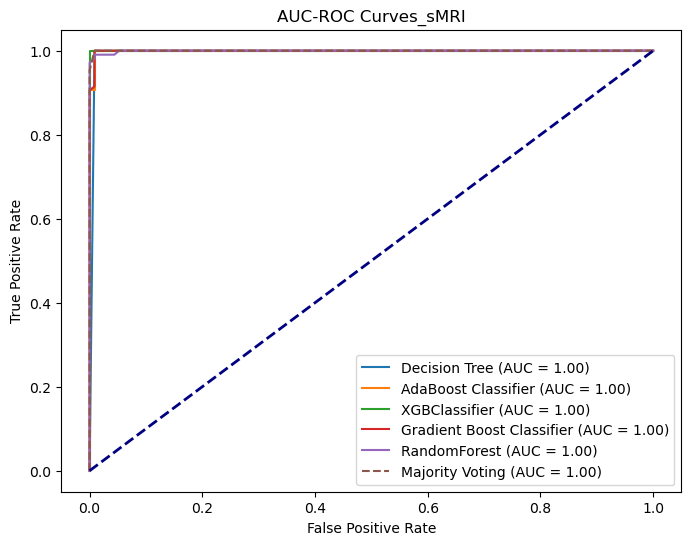

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Read the data
data = pd.read_csv('data_phenotypic.csv')

# Data preprocessing (replacing 2 with 0 for the target variable 'DX_GROUP')
data['DX_GROUP'] = data['DX_GROUP'].replace(2, 0)

# Defining feature matrix X and target vector y
X = data.drop('DX_GROUP', axis=1)
y = data['DX_GROUP']

# Splitting data into training and testing sets (80% train, 20% test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Create instances of the classifiers
decision_tree = DecisionTreeClassifier()
adaboost_classifier = AdaBoostClassifier()
xgb_classifier = XGBClassifier()
gradient_boost_classifier = GradientBoostingClassifier()
random_forest = RandomForestClassifier()

# Define the models in a dictionary
models = {
    "Decision Tree": decision_tree,
    "AdaBoost Classifier": adaboost_classifier,
    "XGBClassifier": xgb_classifier,
    "Gradient Boost Classifier": gradient_boost_classifier,
    "RandomForest": random_forest
}

# Define majority voting classifier
majority_voting_classifier = VotingClassifier(estimators=list(models.items()), voting='hard')

# Train each individual classifier
for name, model in models.items():
    model.fit(X_train, y_train)

# Train the majority voting classifier
majority_voting_classifier.fit(X_train, y_train)

# Initialize lists to store metrics
model_names = list(models.keys()) + ['Majority Voting']
precision_scores = []
recall_scores = []
f1_scores = []
accuracy_scores = []
specificity_scores = []

# Function to calculate specificity from confusion matrix
def calculate_specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return specificity

# Predictions for each individual classifier on the test set
individual_predictions = {name: model.predict(X_test) for name, model in models.items()}

# Predictions for the majority voting classifier on the test set
majority_voting_predictions = majority_voting_classifier.predict(X_test)

# Calculate metrics for each individual classifier
for name, predictions in individual_predictions.items():
    precision_scores.append(precision_score(y_test, predictions))
    recall_scores.append(recall_score(y_test, predictions))
    f1_scores.append(f1_score(y_test, predictions))
    accuracy_scores.append(accuracy_score(y_test, predictions))
    specificity_scores.append(calculate_specificity(y_test, predictions))

# Calculate metrics for the majority voting classifier
precision_scores.append(precision_score(y_test, majority_voting_predictions))
recall_scores.append(recall_score(y_test, majority_voting_predictions))
f1_scores.append(f1_score(y_test, majority_voting_predictions))
accuracy_scores.append(accuracy_score(y_test, majority_voting_predictions))
specificity_scores.append(calculate_specificity(y_test, majority_voting_predictions))

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Model': model_names,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1 Score': f1_scores,
    'Accuracy': accuracy_scores,
    'Specificity': specificity_scores
})

# Print the results table
print(results_df)

# Plot ROC curves for classifiers that support predict_proba
plt.figure(figsize=(8, 6))
for name, model in models.items():
    if hasattr(model, 'predict_proba'):
        fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Approximate ROC curve for majority voting
majority_probs = np.sum(list(individual_predictions.values()), axis=0) / len(models)
fpr_majority, tpr_majority, _ = roc_curve(y_test, majority_probs)
roc_auc_majority = auc(fpr_majority, tpr_majority)
plt.plot(fpr_majority, tpr_majority, label=f'Majority Voting (AUC = {roc_auc_majority:.2f})', linestyle='--')

# Plotting the diagonal line for random guessing
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', linewidth=2)

# Adding labels and title to the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curves_sMRI')
plt.legend(loc='lower right')

# Save the ROC curve figure
# plt.savefig('roc_curve.png')

# Show the ROC curve plot
plt.show()


## Fusion

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# read the data
data1=pd.read_csv("merged.csv")
data=pd.read_csv('data_phenotypic.csv')
# data.head()
# data1.drop("Unnamed: 0",inplace=True,axis=1)
data['DX_GROUP']=data['DX_GROUP'].replace(2,0)

X = data1
y = data['DX_GROUP']

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)
# Create instances of the classifiers
decision_tree = DecisionTreeClassifier()
adaboost_classifier = AdaBoostClassifier()
xgb_classifier = XGBClassifier()
# lgbm_classifier = lgb.LGBMClassifier()
gradient_boost_classifier = GradientBoostingClassifier()
random_forest = RandomForestClassifier()

# Define the majority voting classifier
models = {
    "Decision Tree": decision_tree,
    "AdaBoost Classifier": adaboost_classifier,
    "XGBClassifier": xgb_classifier,
    # "LightGBM Classifier": lgbm_classifier,
    "Gradient Boost Classifier": gradient_boost_classifier,
    "RandomForest": random_forest
}

majority_voting_classifier = VotingClassifier(estimators=list(models.items()), voting='hard')

# Train each individual classifier
for name, model in models.items():
    model.fit(X_train, y_train)

# Train the majority voting classifier
majority_voting_classifier.fit(X_train, y_train)

# Initialize lists to store metrics
model_names = list(models.keys()) + ['Majority Voting']
precision_scores = []
recall_scores = []
f1_scores = []
accuracy_scores = []

# Predictions for each individual classifier on the test set
individual_predictions = {name: model.predict(X_test) for name, model in models.items()}

# Predictions for the majority voting classifier on the test set
majority_voting_predictions = majority_voting_classifier.predict(X_test)

# Calculate metrics for each individual classifier
for name, predictions in individual_predictions.items():
    precision_scores.append(precision_score(y_test, predictions))
    recall_scores.append(recall_score(y_test, predictions))
    f1_scores.append(f1_score(y_test, predictions))
    accuracy_scores.append(accuracy_score(y_test, predictions))

# Calculate metrics for the majority voting classifier
precision_scores.append(precision_score(y_test, majority_voting_predictions))
recall_scores.append(recall_score(y_test, majority_voting_predictions))
f1_scores.append(f1_score(y_test, majority_voting_predictions))
accuracy_scores.append(accuracy_score(y_test, majority_voting_predictions))

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Model': model_names,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1 Score': f1_scores,
    'Accuracy': accuracy_scores
})

# Print the results table
print(results_df)

# Plot ROC curves for classifiers that support predict_proba
plt.figure(figsize=(8, 6))
for name, model in models.items():
    if hasattr(model, 'predict_proba'):
        fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Approximate ROC curve for majority voting
majority_probs = np.sum(list(individual_predictions.values()), axis=0) / len(models)
fpr_majority, tpr_majority, _ = roc_curve(y_test, majority_probs)
roc_auc_majority = auc(fpr_majority, tpr_majority)
plt.plot(fpr_majority, tpr_majority, label=f'Majority Voting (AUC = {roc_auc_majority:.2f})', linestyle='--')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--', linewidth=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curves_sMRI')
plt.legend(loc='lower right')
plt.savefig('roc_curve.png')
plt.show()
